In [5]:
import numpy as np
from bresenham import bresenham_algorithm
from matplotlib.image import imread
import matplotlib.pyplot as plt
from skimage import color

In [7]:
# Stałe - w końcowym rozwiązaniu trzeba będzie je wyliczyć na podstawie danego obrazka albo dać do ustawienia użytkownikowi
INTERVAL = np.pi / 12  # Co jaki kąt przesuwany jest emitter po okręgu

DETECTORS_NUMBER = 5  # liczba detektorów
EXTENT = 30 * np.pi / 180  # jaka jest rozpiętość kątowa detectors

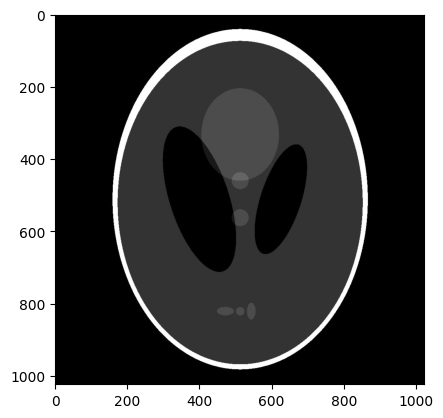

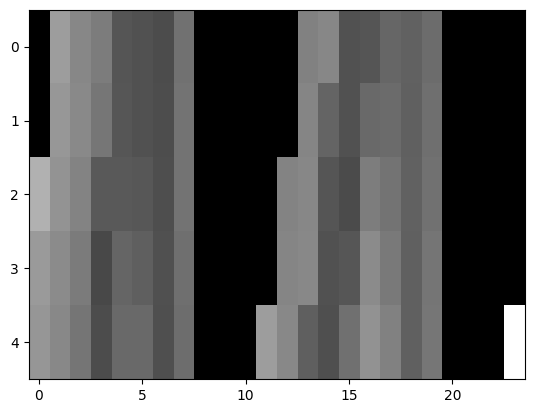

In [14]:
sinogram = np.zeros((int(2 * np.pi / INTERVAL), DETECTORS_NUMBER))
image = imread("./images/Shepp_logan.jpg")
image = color.rgb2gray(image)
X = image.shape[0] / 2 # współrzędna X środka obrazka
Y = image.shape[1] / 2  # współrzędna Y środka obrazka
R = np.sqrt(X ** 2 + Y ** 2)  # długość promienia okręgu, po którym będzie "poruszać się" emitter

# W zewnętrznej pętli wyznaczamy kolejne pozycje emitera, będą one o 0 do 2pi z odstępem co INTERVAL
for emitter_idx, emitter_angle in zip(range(int(2 * np.pi / INTERVAL)), np.arange(0, 2 * np.pi, INTERVAL)):
    # wyznaczamy współrzędne (x, y) emittera na podstawie wartości X, Y oraz R i kąta (emitter_angle) z danej interacji
    emitter_coordinates = [int(X + R * np.cos(emitter_angle)), int(Y + R * np.cos(emitter_angle))]

    # W wewnętrznej pętli wyznaczamy pozycje detectorów
    detector_start = emitter_angle + np.pi - EXTENT / 2
    detector_end = emitter_angle + np.pi + EXTENT / 2
    for detector_idx, detector_angle in zip(range(DETECTORS_NUMBER), np.arange(detector_start, detector_end, EXTENT / DETECTORS_NUMBER)):
        # wyznaczamy współrzędne (x, y) detectora
        detector_coordinates = [int(X + R * np.cos(detector_angle)), int(Y + R * np.sin(detector_angle))]

        # korzystając z algorytmu bresenham_algorithm wyliczamy punkty leżące na linii pomiędzy emitter i detector
        line_points = list(bresenham_algorithm(emitter_coordinates[0], emitter_coordinates[1],
                                               detector_coordinates[0], detector_coordinates[1]))

        points_on_line = 0  # licznik punktów które znajdują się na obrazku
        values_sum = 0
        # iterujemy po punktach wyznaczonych przed chwilą
        for point in line_points:
            if 0 <= point[0] < X * 2 and 0 <= point[1] < Y * 2:
                # jeżeli punkt należy do obrazka dodajemy 1 do licznika punktów i zwiększamy wartość sumy o wartość z punktu na obrazku wejściowym
                points_on_line += 1
                values_sum += image[point[0]][point[1]]
        if points_on_line > 0:
            # do sinogramu w odpowiednią komórkę wstawiamy wartość sumy uzyskaną w pętli powyżej podzieloną przez liczbę punktów
            sinogram[emitter_idx][detector_idx] = values_sum / points_on_line
        else:
            sinogram[emitter_idx][detector_idx] = 0

plt.imshow(image, cmap='gray')
plt.show()
plt.imshow(sinogram.T, aspect='auto', cmap='gray')
plt.show()